# nueral style を関数にまとめる
- 1つの関数を実行したら処理が完了するように実装
- 引数は2つ。1つ目はorigin の画像のパス、2つ目は変換した画像の保存先

In [1]:
# Import!
import torch
import torch.nn as nn
import torch.optim as optim

import copy
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms

import cv2
import copy
import warnings
warnings.simplefilter("ignore")

In [46]:
# Hyperparameters
MAX_IMAGE_SIZE = 512

# Optimizer
OPTIMIZER = 'adam' #or 'lbfgs'
ADAM_LR = 10
CONTENT_WEIGHT = 5e0
STYLE_WEIGHT = 1e2
TV_WEIGHT = 1e-3
NUM_ITER = 500
SHOW_ITER = 100

# Image Files
INIT_IMAGE = 'random' # or 'content'
PRESERVE_COLOR = 'False' # 'False'
PIXEL_CLIP = 'True' # or False - Clipping produces better images
CONTENT_PATH = 'images/1-content.png'
STYLE_PATH = 'images/1-style.jpg'

VGG19_PATH = 'models/vgg19-d01eb7cb.pth'
POOL = 'max'

In [47]:
# Utils
# Load image file
def load_image(path):
    # Images loaded as BGR
    img = cv2.imread(path)
    return img

# Show image
def show(img):
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # imshow() only accepts float [0,1] or int [0,255]
    img = np.array(img/255).clip(0,1)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.show()

# Save Image as out{num_iterms}.png
def saveimg(img, iters):
    if (PIXEL_CLIP=='True'):
        img = img.clip(0, 255)
    cv2.imwrite('out'+str(iters)+'.png', img)

# Color transfer
def transfer_color(src, dest):
    if (PIXEL_CLIP=='True'):
        src, dest = src.clip(0,255), dest.clip(0,255)

    # Resize src to dest's size
    H,W,_ = src.shape
    dest = cv2.resize(dest, dsize=(W, H), interpolation=cv2.INTER_CUBIC)

    dest_gray = cv2.cvtColor(dest, cv2.COLOR_BGR2GRAY) #1 Extract the Destination's luminance
    src_yiq = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)   #2 Convert the Source from BGR to YIQ/YCbCr
    src_yiq[...,0] = dest_gray                         #3 Combine Destination's luminance and Source's IQ/CbCr

    return cv2.cvtColor(src_yiq, cv2.COLOR_YCrCb2BGR)  #4 Convert new image from YIQ back to BGR

In [48]:
# Preprocessing
def itot(img):
    # Rescale the image
    H, W, C = img.shape
    image_size = tuple([int((float(MAX_IMAGE_SIZE) / max([H,W]))*x) for x in [H, W]])
    
    itot_t = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    
    # Subtract the means
    normalize_t = transforms.Normalize([103.939, 116.779, 123.68],[1,1,1])
    tensor = normalize_t(itot_t(img)*255)
    
    # Add the batch_size dimension
    tensor = tensor.unsqueeze(dim=0)
    return tensor

def ttoi(tensor):
    # Add the means
    ttoi_t = transforms.Compose([
        transforms.Normalize([-103.939, -116.779, -123.68],[1,1,1])])
    
    # Remove the batch_size dimension
    tensor = tensor.squeeze()
    img = ttoi_t(tensor)
    img = img.cpu().numpy()
    
    # Transpose from [C, H, W] -> [H, W, C]
    img = img.transpose(1, 2, 0)
    return img

In [49]:
TRANSFER_PATH = './'

In [50]:
# Change Pooling Layer
def pool_(model, pool='avg'):
    if (pool=='avg'):
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.MaxPool2d):
                model[ct] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
            ct+=1
    elif (pool=='max'):
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.AvgPool2d):
                model[ct] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            ct+=1
            
    return model

In [51]:
mse_loss = torch.nn.MSELoss()
def gram(tensor):
    B, C, H, W = tensor.shape
    x = tensor.view(C, H*W)
    return torch.mm(x, x.t())

def content_loss(g, c):
    loss = mse_loss(g, c)
    return loss
    
def style_loss(g, s):
    c1,c2 = g.shape
    loss = mse_loss(g, s)
    return loss / (c1**2) # Divide by square of channels



In [52]:
# VGG Forward Pass
def get_features(model, tensor):
    layers = {
        '3': 'relu1_2',   # Style layers
        '8': 'relu2_2',
        '17' : 'relu3_3',
        '26' : 'relu4_3',
        '35' : 'relu5_3',
        '22' : 'relu4_2', # Content layers
        #'31' : 'relu5_2'
    }
    
    # Get features
    features = {}
    x = tensor
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            if (name=='22'):   # relu4_2
                features[layers[name]] = x
            elif (name=='31'): # relu5_2
                features[layers[name]] = x
            else:
                b, c, h, w = x.shape
                features[layers[name]] = gram(x) / (h*w)
                
            # Terminate forward pass
            if (name == '35'):
                break
            
    return features

In [53]:
# Generate Initial Image
def initial(content_tensor, init_image='random'):
    B, C, H, W = content_tensor.shape
    if (init_image=='random'):
        tensor = torch.randn(C, H, W).mul(0.001).unsqueeze(0)
    else:
        tensor = content_tensor.clone().detach()
    
    return tensor


In [54]:
def stylize(vgg_model, content_tensor, style_tensor, optimizer, g, iteration=NUM_ITER):
    # Get features representations/Forward pass
    content_layers = ['relu4_2']
    content_weights = {'relu4_2': 1.0} 
    style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
    style_weights = {'relu1_2': 0.2, 'relu2_2': 0.2, 'relu3_3': 0.2, 'relu4_3': 0.2, 'relu5_3': 0.2}
    c_feat = get_features(vgg_model, content_tensor)
    s_feat = get_features(vgg_model, style_tensor)
    
    result_img = None
    i = [0]
    while i[0] < iteration:
        def closure():
            # Zero-out gradients
            optimizer.zero_grad()

            # Forward pass
            g_feat = get_features(vgg_model, g)

            # Compute Losses
            c_loss=0
            s_loss=0
            for j in content_layers:
                c_loss += content_weights[j] * content_loss(g_feat[j], c_feat[j])
            for j in style_layers:
                s_loss += style_weights[j] * style_loss(g_feat[j], s_feat[j])
            
            c_loss = CONTENT_WEIGHT * c_loss
            s_loss = STYLE_WEIGHT * s_loss
            # t_loss = TV_WEIGHT * tv_loss(g.clone().detach())
            # total_loss = c_loss + s_loss + t_loss
            total_loss = c_loss + s_loss

            # Backprop
            total_loss.backward(retain_graph=True)
            
            # Print Loss, show and save image
            i[0]+=1
            # SHOW_ITER= 100, NUM_ITER = 500
            # if (((i[0] % SHOW_ITER) == 1) or (i[0]==NUM_ITER)):
            if (i[0]==NUM_ITER):
                print("Style Loss: {} Content Loss: {} Total Loss : {}".format(s_loss.item(), c_loss.item(), total_loss.item()))
                if (PRESERVE_COLOR=='True'):
                    g_ = transfer_color(ttoi(content_tensor.clone().detach()), ttoi(g.clone().detach()))
                else:
                    g_ = ttoi(g.clone().detach())
                show(g_)
                saveimg(g_, i[0]-1)
                plt.show()
            
            return (total_loss)
        
        # Weight/Pixel update
        optimizer.step(closure)
    # saveimg(g_, i[0]-1)
    return g

content images/1-content.png
STYLE_PATH images/1-style.jpg
Style Loss: 137895.0625 Content Loss: 598558.0625 Total Loss : 736453.125


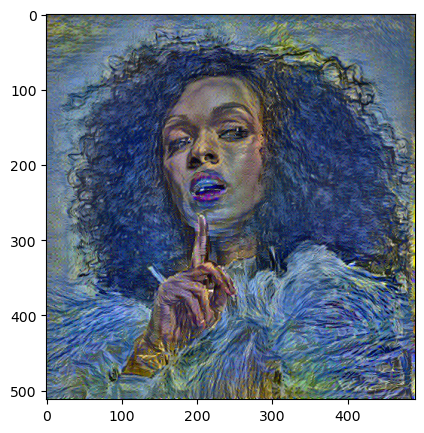

In [55]:

def nueral_style(CONTENT_PATH, STYLE_PATH, TRANSFER_PATH):
    # mps 環境によって変える
    device = ("cuda" if torch.cuda.is_available() else "mps")
    
    # vgg19モデルの重みのロード
    vgg = models.vgg19(pretrained=False)
    vgg.load_state_dict(torch.load(VGG19_PATH), strict=False)
    model = copy.deepcopy(vgg.features)
    model.to(device)

    # 不要な勾配の更新を消す
    for param in model.parameters():
        param.requires_grad = False

    print("content",CONTENT_PATH)
    print("STYLE_PATH",STYLE_PATH)

    content_img = load_image(CONTENT_PATH)
    style_img = load_image(STYLE_PATH)

    content_tensor = itot(content_img).to(device)
    style_tensor = itot(style_img).to(device)
    g = initial(content_tensor, init_image=INIT_IMAGE)
    g = g.to(device).requires_grad_(True)

    learnig_rate = 0.01
    if (OPTIMIZER=='lbfgs'):
        optimizer = optim.LBFGS([g],lr=learnig_rate)
    else:
        optimizer = optim.Adam([g], lr=ADAM_LR)

    out = stylize(model, content_tensor, style_tensor, optimizer, g, iteration=NUM_ITER)

nueral_style(CONTENT_PATH, STYLE_PATH, TRANSFER_PATH)